# w261 Final Project - Clickthrough Rate Prediction


[Team 15]   
[Anu Yadav, Connor Stern, Erik Hou, Noah Pflaum]   
Summer 2019, section [Hou, Stern, Yadav: Section 3; Pflaum: Section 5]   

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

In [1]:
from pyspark.sql import types
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml.feature import FeatureHasher
from pyspark.ml.classification import LogisticRegression

In [3]:
# Set the variable to True if running spark locally, to False if running this notebook using week 08 environment
local = False

In [4]:

if local:
    # run if using local
    app_name = "final_project"
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
    # get the working directory
    PWD = !pwd
    PWD = PWD[0]
    
else:
    # run if using wk08 environment
    sqlContext = SQLContext(sc)
    
sc = spark.sparkContext

In [ ]:
sc.getConf().getAll()

# __Section 1__ - Question Formulation

The goal of our analysis is to predict the clickthrough rate in online advertising. In online advertising platforms, advertisers publihs ads to websites where potential customers can view and click on them. For example, Nike as an advertiser might post an ad for running shoes on the ESPN.com website or in a google search for shoes. The position of the ad, the audience and the time that the ad is displayed may all significantly influence a user decision to click on it. 

Since several billions of ads are posted online each day, there is a vast amount of user log data that is collected showing the ad placement and whether or not a user clicked on an ad. 

The goal is to build a model that can predict given the features of the ad whether or not a user will click on the ad. 

A baseline for any model would be to measure the average click-through rate (CTR, percent of ads clicked). We also focus on __log-loss__ as a measure of the performance of the model since it provides better calibrated probabilities. To be practically useful we would want a prediction accuracy that is higher than the baseline, which we get currently with no model. 

In this project, we seek to build a Field-Aware Factorization Machine (FFM) model for CTR prediction, inspired by Juan, Zhuang, Chin, & Lin (paper reference), who were able to win multiple CTR-prediction competitions with such a model. 

While their approach to the problem makes use of a custom library that they wrote called LibFFM we wanted to explore how tis algorithm might be implemented using the techniques we learned in this class, such as pyspark and distributed computing using map/reduce patterns. The paper outlines an approach using the Hogwild algorithm that allows for concurrent updates to a sparse matrix of model coefficients which eliminates some of the issues with the communication and synchronization barriers that exist in using stochastic gradient descent. We do not expect our algorithm to be as performant as a customized C++ implmentation, instead we highlight the application of the ideas learned in this class to creating predicitve models for big data.

# __Section 2__ - Algorithm Explanation

Because an online advertisement can either be clicked ($response = 1$) or not ($response = 0$) , Click-Through-Rate (CTR) Prediction is generally treated as a logistic regression problem. For any set of features, we calculate some value $s$, and perform the logit transformation to yield our CTR prediction:
$$CTR = \frac{1}{1+e^{-s}} $$

There are several methods we can use to estimate $s$, each with its own benefits and drawbacks. Typical implementations include a linear model, a degree-2 polynomial mapping, a factorization machine, and a field-aware factorization machine. 

We will consider an example with the following dataset as we discuss the different methods of estimating $s$:

<table>
<th>Response</th>
<th>Publisher</th>
<th>Advertiser</th>
<th>Gender</th>
<tr><td>1</td><td>Netflix</td><td>Pepsi</td><td>Male</td></tr>
<tr><td>0</td><td>Spotify</td><td>Pepsi</td><td>Male</td></tr>
<tr><td>0</td><td>Facebook</td><td>Gatorade</td><td>Female</td></tr>
<tr><td>1</td><td>Spotify</td><td>Coca-cola</td><td>Male</td></tr>
<tr><td>1</td><td>Facebook</td><td>Coca-cola</td><td>Female</td></tr>
<tr><td>0</td><td>Facebook</td><td>Pepsi</td><td>Female</td></tr>
<tr><td>1</td><td>Netflix</td><td>Gatorade</td><td>Female</td></tr>
</table>

In this dataset, we refer to the categories Publisher, Advertiser, and Gender as "fields" and the labels within each field (Netflix, Spotify, Facebook, Pepsi, Gatorade, Coca-cola, Male, Female) as "features."

#### Linear Model
In a linear model, the algorithm learns a weight for every given feature. The formulation of the model is:
$$s = \phi(\textbf{w},\textbf{x}) =\textbf{w}^T \textbf{x}  =\sum_{j \epsilon C_1}w_jx_j$$
where $\textbf{w}$ is the learned model, $\textbf{x}$ is the data observation, and $C_1$ is the non-zero elements in $\textbf{x}$. 

In our toy example, our model would learn different weights for the different Publishers (Netflix, Spotify, and Pepsi), Advertisers (Pepsi, Gatorade, and Coca-cola), and Genders (Male, Female). The value $s$ would then be calculated for each impression using these different weights. Thus, for each impression we would have have:

$$
\begin{aligned}
s =& w_{Netflix}\cdot x_{Netflix} + w_{Spotify}\cdot x_{Spotify} + w_{Facebook}\cdot x_{Facebook} \\
&+ w_{Coca-cola}\cdot x_{Coca-cola} + w_{Pepsi}\cdot x_{Pepsi} + w_{Gatorade}\cdot x_{Gatorade} \\
&+ + w_{Male}\cdot x_{Male} + w_{Female}\cdot x_{Female}
\end{aligned}
$$

For our first impression of the dataset (Netflix, Pepsi, Male) this becomes:
$$s = w_{Netflix} + w_{Coca-cola} + w_{Male}$$
since $x_j = 1$ for Netflix, Pepsi, and Male while $x_j = 0$ for all other features. 


This model is simple and efficient, yet it does not allow for interactive effects between features. For example, Coca-cola may have a higher CTR with Netflix than another publisher. A linear model is unable to learn this type of information, as it essentially learns the "average effect" of each feature.

#### Degree-2 Polynomial Mapping
The simplest way to learn the effect of the "feature conjunction" described above (in the case where a particular advertiser may have a higher CTR with one publisher compared to others) is to use a degree-2 polynomial mapping. In this model, the algorithm learns an additional weight for each feature pair. The formulation of the model is:
$$s = \phi(\textbf{w},\textbf{x}) = \sum_{j_1, j_2 \epsilon C_2} w_{j_1,j_2} \cdot x_{j_1}x_{j_2}$$
where $C_2$ is the pairwise combination of non-zero elements in $\textbf{x}$.


Returning to our example dataset and the impression with the features Netflix, Pepsi, and Male the model would be:
$$s = w_{Netflix} + w_{Pepsi} + w_{Male} + w_{Netflix,Pepsi} + w_{Netflix,Male} + w_{Pepsi,Male}$$

While this model improves on the linear model by allowing us to account for interactions between features, it does not handle sparse datasets well. Since we have 0 impressions of the advertiser Gatorade with the publisher Spotify, the model prediction will be trivial as no weight was learned for this feature combination. The model is also susceptible to overfitting, as it generates unreliable predictions for feature combinations with a very small number of impressions.

#### Factorization Machine
Factorization Machines (FM) begin to provide us a solution to the problem of sparse datasets. Here the model learns a latent vector, rather than an explicit weight, for each feature. The model formulation is:
$$s = \phi(\textbf{w},\textbf{x}) = \sum_{j_1, j_2 \epsilon C_2} \langle \textbf{w}_{j_1}, \textbf{w}_{j_2} \rangle x_{j_1}x_{j_2}$$
where $\textbf{w}_{j_1}$ and $\textbf{w}_{j_2}$ are two learned latent vectors of length $k$ (some user-defined parameter).

Returning to our example of an impression with the features of Netflix, Pepsi, and Male, the FM model would be:
$$s = w_{Netflix} \cdot w_{Pepsi} + w_{Netflix} \cdot w_{Male} + w_{Pepsi} \cdot w_{Male}$$
where $w_{Netflix}, w_{Pepsi}, w_{Male} \epsilon {\rm I\!R}^k$.

This allows the model to learn the latent vectors for each feature based on all the data points for that feature, and these latent vectors can be used to predict the CTR for unobserved feature combinations (such as Spotify and Gatorade, as previously mentioned), something the degree-2 polynomial mapping method did not allow us to do.

We notice in our example above, however, that the latent vector $w_{Netflix}$ is used twice: once to calculate the latent effect of the Publisher Netflix with the Advertiser Pepsi ($w_{Netflix} \cdot w_{Pepsi}$), and once to calculate the latent effect of the Publisher Netflix with the Gender Male ($w_{Netflix} \cdot w_{Male}$). Yet the latent effect for publisher with advertiser could be very different from the latent effect for publisher with gender, and as such the Factorization Machine model is too restrictive and unrealistic.


#### Field-Aware Factorization Machine
Field-Aware Factorization Machines (FFM) provide a solution to this problem by introducing the flexibility to learn multiple latent vectors for each feature. In the context of the above example, the FFM model will learn two separate latent vectors for Netflix: $w_{Netflix, A}$, which will be used for the calculation of $P \times A$ (to learn the latent effect of Netflix with a given advertiser), and $w_{Netflix, G}$. $w_{Netflix, A}$, for the calculation of $P \times G$ (to learn the latent effect of Netflix with a given gender).

Specifically, the FFM model formulation with the (Netflix, Pepsi, Male) impression gives us:

$$s = w_{Netflix, A} \cdot w_{Pepsi, P} + w_{Netflix, G} \cdot w_{Male, P} + w_{Pepsi, G} \cdot w_{Male, A}$$

Now, the latent effect of (Netflix, Pepsi), is learned by using the latent vector $w_{Netflix, A}$, since Pepsi belongs to the advertiser field (A). The latent effect of (Netflix, Male), by contrast, is learned using a different latent vector, $w_{Netflix, G}$, since Male belongs to the gender field (G). In this way, FFM splits the latent factors for $P \times A$ and $P \times G$, something the traditional Factorization Machine is unable to do. 

The full model formulation for a Field-Aware Factorization Machine is:
$$s = \phi(\textbf{w},\textbf{x}) = \sum_{j_1, j_2 \epsilon C_2} \langle \textbf{w}_{j_1, f_2}, \textbf{w}_{j_2, f_1} \rangle x_{j_1}x_{j_2}$$

where $f_1$ and $f_2$ are the fields of $j_1$ and $j_2$, respectively. 
#### Optimization

As part of a logistic regression problem, the goal is to find the set of parameters that minimize the log-loss function, defined by:

$$ LogLoss = - \frac{1}{n} \sum_{i=1}^n [y_i \cdot log_e(\hat{y_i}) + (1-y_i) \cdot log_e(1-\hat{y_i})] $$


where $n$ is the number of impressions, $y_i$ is the true CTR of impression $i$, and $\hat{y_i}$ is the predicted CTR of impression $i$, $\frac{1}{1+e^{-s_i}}$.

For a given impression $x_i$, we have two cases:
* If $y-i = 1$:
$$
\begin{aligned}
loss &= -log_e(\hat{y_i}) \\
&= -log_e \left( \frac{1}{1+e^{-s}} \right) \\
&= log_e (1+e^{-s})
\end{aligned}
$$

* If $y_i = 0$:
$$
\begin{aligned}
loss &= -log_e(1-\hat{y_i}) \\
&= -log_e \left( 1 - \frac{1}{1+e^{-s}} \right)\\
&= -log_e \left( \frac{1 + e^{-s} - 1}{1+e^{-s}} \right) \\
&= -log_e \left( \frac{e^-s}{1+e^{-s}} \right) \\
&= -log_e \left( \frac{1}{1+e^{s}} \right) \\
&= log_e(1+e^{s})
\end{aligned}
$$

As such, the loss for impression $x_i$ can be written as:
$$log(1+exp(-\bar{y_i}\cdot s_i)$$
where 
$$\bar{y_i} = 
\begin{cases}
    1,\ if\ y_i=1\\
    -1,\ if\ y_i=0\\
\end{cases}$$

Therefore, we can rewrite the log-loss function as:
$$ Loss = \frac{1}{n} \sum_{i=1}^n log(1+exp(-\bar{y_i}\cdot s_i))$$
where 
$\bar{y_i} = 
\begin{cases}
    1,\ if\ y_i=1\\
    -1,\ if\ y_i=0\\
\end{cases}$


and $s = \phi(\textbf{w},\textbf{x}_i) = \sum_{j_1, j_2 \epsilon C_2} \langle \textbf{w}_{j_1, f_2}, \textbf{w}_{j_2, f_1} \rangle x_{j_1}x_{j_2}$


Introducing regularization, the optimization problem we have is:

$$ \min_{\textbf{w}} \sum_{i=1}^m \left( log(1+exp(-\bar{y_i}\phi(\textbf{w},\textbf{x}_i)) + \frac{\lambda}{2}\|\textbf{w}\|^2 \right)$$

$m$ is the number of impressions, and  $\lambda$ is our regularization parameter.

We solve this optimization problem using gradient descent methods.


#### Toy example: FFM in action

We will now walk through an entire iteration of the FFM algorithm to learn a CTR prediction model.
For our work here, we will utilize a hashed representation of our dataset. In this representation, each field is represented by the first integer in the hash, and the feature within that field is represented by the second integer. The Publisher field is represented by the integer 1, the Advertiser field by the integer 2, and the Gender field by the integer 3. Within the Publisher field, Netflix is represented by the integer 1, Spotify by 2, and Facebook by 3. Within the Advertiser field, Pepsi is represented by the integer 1, Gatorade by 2, and Coca-cola by 3. Within the Gender field, Male is represented by 1 and Female by 2. Using this hash representation, our first impression of (Netflix, Pepsi, Male) has the features 1:1, 2:1, 3:1.
The full hashed representation of our dataset is shown below:

<table>
<th>Impression</th>
<th>Response</th>
<th>Features</th>
<tr><td>1</td><td>1</td><td>1:1, 2:1, 3:1</td></tr>
<tr><td>2</td><td>1</td><td>1:2, 2:1, 3:1</td></tr>
<tr><td>3</td><td>0</td><td>1:3, 2:2, 3:2</td></tr>
<tr><td>4</td><td>0</td><td>1:2, 2:3, 3:1</td></tr>
<tr><td>5</td><td>1</td><td>1:3, 2:3, 3:2</td></tr>
<tr><td>6</td><td>0</td><td>1:3, 2:1, 3:2</td></tr>
<tr><td>7</td><td>1</td><td>1:1, 2:2, 3:2</td></tr>
<table>

In [57]:
%%writefile data/toy_set.txt
1	1	1	1	1
2	1	2	1	1
3	0	3	2	2
4	0	2	3	1
5	1	3	3	2
6	0	3	1	2
7	1	1	2	2

Overwriting data/toy_set.txt


In [58]:
toyRDD = sc.textFile('data/toy_set.txt')

__1)__ We define k (the length of our latent vectors) to be 3.

__2)__ We randomly initialize our latent vectors $\textbf{w}$. For the Publisher field, each feature will have two different latent vectors (represented by columns below)--one corresponding to Advertiser (A), and one corresponding to Gender (G):

In [34]:
W_P = np.random.uniform(-1.7,1.7, size=(6,3)).round(1)
W_P

array([[ 0.9, -0.2, -0.2],
       [-0.6, -0. , -0.3],
       [-0.1, -0.5, -1.2],
       [-1.1,  0.2,  1.2],
       [ 1.4, -0.7,  0.7],
       [ 0. ,  0.8,  0.1]])

<table>
<th>$\textbf{w}_{Netflix,A}$</th>
<th>$\textbf{w}_{Netflix,G}$</th>
<th>$\textbf{w}_{Spotify,A}$</th>
<th>$\textbf{w}_{Spotify,G}$</th>
<th>$\textbf{w}_{Facebook,A}$</th>
<th>$\textbf{w}_{Facebook,G}$</th>
<tr><td>0.9</td><td>-0.6</td><td>-0.1</td><td>-1.1</td><td>1.4</td><td>0</td></tr>
<tr><td>-0.2</td><td>0</td><td>-0.5</td><td>0.2</td><td>-0.7</td><td>0.8</td></tr>
<tr><td>-0.2</td><td>-0.3</td><td>-1.2</td><td>1.2</td><td>0.7</td><td>0.1</td></tr>
<table>
The Advertiser field will similarly have two different latent vectors for each feature--one for Publisher (P), and one for Gender (G):

In [35]:
W_A = np.random.uniform(-1.7,1.7, size=(6,3)).round(1)
W_A

array([[ 1. , -0.3, -0.1],
       [-0.4, -1. , -0. ],
       [-0.2, -1. , -1.7],
       [ 0.7, -0.3, -1.1],
       [ 0.1,  1.3, -0.2],
       [ 0.5,  0.2,  0.5]])

<table>
<th>$\textbf{w}_{Pepsi,P}$</th>
<th>$\textbf{w}_{Pepsi,G}$</th>
<th>$\textbf{w}_{Gatorade,P}$</th>
<th>$\textbf{w}_{Gatorade,G}$</th>
<th>$\textbf{w}_{Coca-cola,P}$</th>
<th>$\textbf{w}_{Coca-cola,G}$</th>
<tr><td>1</td><td>-0.4</td><td>-0.2</td><td>0.7</td><td>0.1</td><td>0.5</td></tr>
<tr><td>-0.3</td><td>-1</td><td>-1</td><td>-0.3</td><td>-1.3</td><td>0.2</td></tr>
<tr><td>-0.1</td><td>0</td><td>-1.7</td><td>-1.1</td><td>-0.2</td><td>0.5</td></tr>
<table>

The Gender field will also have two different latent vectors per feature (one for Publisher (P), one for Advertiser (A)): 

In [36]:
W_G = np.random.uniform(-1.7,1.7, size=(4,3)).round(1)
W_G

array([[-0.4,  0.8,  1.5],
       [-0.9,  1.3, -1. ],
       [ 0.8, -1.5,  0.3],
       [ 0.4,  0.7,  0.5]])

<table>
<th>$\textbf{w}_{Male,P}$</th>
<th>$\textbf{w}_{Male,A}$</th>
<th>$\textbf{w}_{Female,P}$</th>
<th>$\textbf{w}_{Female,A}$</th>
<tr><td>-0.4</td><td>-0.9</td><td>0.8</td><td>0.4</td></tr>
<tr><td>0.8</td><td>1.3</td><td>-1.5</td><td>0.7</td></tr>
<tr><td>1.5</td><td>-1</td><td>0.3</td><td>0.5</td></tr>
<table>

__3)__ We calculate $s$ for each impression using these weight vectors.

For each impression, we would use the formula
$$s = \phi(\textbf{w},\textbf{x}) = \sum_{j_1, j_2 \epsilon C_2} \langle \textbf{w}_{j_1, f_2}, \textbf{w}_{j_2, f_1} \rangle x_{j_1}x_{j_2}$$    
to generate our value of $s$. Fully expanded, this would be:
    
$$
\begin{aligned}
s =& \langle\textbf{w}_{Netflix,A} \cdot \textbf{w}_{Pepsi,P}\rangle x_{Netflix}x_{Pepsi} + \langle\textbf{w}_{Netflix,A} \cdot \textbf{w}_{Coca-cola,P}\rangle x_{Netflix}x_{Coca-cola} + \langle\textbf{w}_{Netflix,A} \cdot \textbf{w}_{Gatorade,P}\rangle x_{Netflix}x_{Gatorade} \\
&+ \langle\textbf{w}_{Netflix,G} \cdot \textbf{w}_{Male,P}\rangle x_{Netflix}x_{Male} + \langle\textbf{w}_{Netflix,G} \cdot \textbf{w}_{Female,P}\rangle x_{Netflix}x_{Female} + \langle\textbf{w}_{Spotify,A} \cdot \textbf{w}_{Pepsi,P}\rangle x_{Spotify}x_{Pepsi} \\
&+ \langle\textbf{w}_{Spotify,A} \cdot \textbf{w}_{Coca-cola,P}\rangle x_{Spotify}x_{Coca-cola} + \langle\textbf{w}_{Spotify,A} \cdot \textbf{w}_{Gatorade,P}\rangle x_{Spotify}x_{Gatorade} + \langle\textbf{w}_{Spotify,G} \cdot \textbf{w}_{Male,P}\rangle x_{Spotify}x_{Male} \\
&+ \langle\textbf{w}_{Spotify,G} \cdot \textbf{w}_{Female,P}\rangle x_{Spotify}x_{Female} + \langle\textbf{w}_{Facebook,A} \cdot \textbf{w}_{Pepsi,P}\rangle x_{Facebook}x_{Pepsi} + \langle\textbf{w}_{Facebook,A} \cdot \textbf{w}_{Coca-cola,P}\rangle x_{Facebook}x_{Coca-cola} \\
&+ \langle\textbf{w}_{Facebook,A} \cdot \textbf{w}_{Gatorade,P}\rangle x_{Facebook}x_{Gatorade} + \langle\textbf{w}_{Facebook,G} \cdot \textbf{w}_{Male,P}\rangle x_{Facebook}x_{Male} + \langle\textbf{w}_{Facebook,G} \cdot \textbf{w}_{Female,P}\rangle x_{Facebook}x_{Female} 
\end{aligned}
$$

For each impression, we are only concerned with the terms containing the features represented in the impression, since these $x$ values are equal to one, while all other terms become zero.
    
Our first impression (Netflix, Pepsi, Male) would therefore give us:
$$
\begin{aligned}
s &= \langle\textbf{w}_{Netflix,A} \cdot \textbf{w}_{Pepsi,P}\rangle + \langle\textbf{w}_{Netflix,G} \cdot \textbf{w}_{Male,P}\rangle + \langle\textbf{w}_{Pepsi,G} \cdot \textbf{w}_{Male,A}\rangle\\
&= (0.9*1 + -0.2*-0.3 + -0.2*-0.1) + (-0.6*-0.4 + 0*0.8 + -0.3*1.5) + (-0.4*-0.9 + -1*1.3 + 0*-1)  \\
&= 0.98 + -0.21 + -0.94 \\
&= -0.17
\end{aligned}
$$


Plugging this value into the logit transformation, we get a predicted CTR of:
$$\frac{1}{1+e^{-s}} = \frac{1}{1+e^{0.17}} \approx 0.46$$
    
Since this value is closer to 0 than 1, we would ultimately predict a non-click (incorrectly). However, this predicted value is vital for our log-loss calculation, which we will see momentarily.

Below we calculate the value of $s$ and predicted CTR for each impression:

In [92]:
W_p = sc.broadcast(W_P)
W_a = sc.broadcast(W_A)
W_g = sc.broadcast(W_G)

def predict(x):
    imp = x[0]
    res = x[2]
    pub = x[4]
    adv = x[6]
    gen = x[8]
    #define appropriate latent vectors to use in calculations
    if pub == '1':
        w_pa = W_p.value[0]
        w_pg = W_p.value[1]
    elif pub == '2':
        w_pa = W_p.value[2]
        w_pg = W_p.value[3]
    else:
        w_pa = W_p.value[4]
        w_pg = W_p.value[5]
    if adv == '1':
        w_ap = W_a.value[0]
        w_ag = W_a.value[1]
    elif adv == '2':
        w_ap = W_a.value[2]
        w_ag = W_a.value[3]
    else:
        w_ap = W_a.value[4]
        w_ag = W_a.value[5]
    if gen == '1':
        w_gp = W_g.value[0]
        w_ga = W_g.value[1]
    else:
        w_gp = W_g.value[2]
        w_ga = W_g.value[3]
    #calculate s using latent vectors
    s = (np.dot(w_pa, w_ap) + np.dot(w_pg, w_gp) + np.dot(w_ag, w_ga)).round(2)
    #calculate CTR
    CTR = np.divide(1,1+np.exp(-s)).round(2)
    yield imp,res, pub, adv, gen, s, CTR

In [93]:
resultRDD = toyRDD.flatMap(predict).cache()
resultRDD.collect()

[('1', '1', '1', '1', '1', -0.17, 0.46),
 ('2', '1', '2', '1', '1', 1.63, 0.84),
 ('3', '0', '3', '2', '2', -2.42, 0.08),
 ('4', '0', '2', '3', '1', 1.29, 0.78),
 ('5', '1', '3', '3', '2', -1.49, 0.18),
 ('6', '0', '3', '1', '2', -0.49, 0.38),
 ('7', '1', '1', '2', '2', -0.69, 0.33)]

Summarized in a table, we have:

<table>
<th>Impression</th>
<th>$s$</th>
<th>Predicted CTR</th>
<th>True Response</th>
<th>Correct?</th>
<tr><td>(Netflix, Pepsi, Male)</td><td>-0.17</td><td>$\approx 0.46$</td><td>1</td><td>No</td></tr>
<tr><td>(Spotify, Pepsi, Male)</td><td>1.63</td><td>$\approx 0.84$</td><td>1</td><td>Yes</td></tr>
<tr><td>(Facebook, Gatoriade, Female)</td><td>-2.42</td><td>$\approx 0.08$</td><td>0</td><td>Yes</td></tr>
<tr><td>(Spotify, Coca-cola, Male)</td><td>1.29</td><td>$\approx 0.78$</td><td>0</td><td>No</td></tr>
<tr><td>(Facebook, Coca-cola, Female)</td><td>-1.49</td><td>$\approx 0.18$</td><td>1</td><td>No</td></tr>
<tr><td>(Facebook, Pepsi, Female)</td><td>-0.49</td><td>$\approx 0.38$</td><td>0</td><td>Yes</td></tr>
<tr><td>(Netflix, Gatorade, Female)</td><td>-0.69</td><td>$\approx 0.33$</td><td>1</td><td>No</td></tr>
<table>

    
__4)__ We can now calculate the log-loss of the model. While this is not necessary in order to find the optimum latent vectors for our model, we show the calculation here using the equation:
$$ LogLoss = - \frac{1}{n} \sum_{i=1}^n [y_i \cdot log_e(\hat{y_i}) + (1-y_i) \cdot log_e(1-\hat{y_i})] $$

Simply put, if our True Response ($y_i$) for an impression is 0, we add the log-value of `1-Predicted CTR` to our sum; if our True Response ($y_i$) for an impression is 1, we add the log-value of `CTR`.    

Using our values from our table above, we have:

$$ \begin{aligned}
LogLoss =& - \frac{1}{7}[log_e(0.46) + log_e(0.84) + log_e(0.92) + log_e(0.22) + log_e(0.18) + log_e(0.62)+ log_e(0.33)]\\
=& 0.8356
\end{aligned}
$$
    
Our hand calculation is confirmed below:

In [103]:
def log_loss(imp):
    #helper function to calculate log(CTR) or log(1-CTR) depending on true response
    resp = imp[1]
    pred = imp[6]
    if resp == '0':
        yield 1, (np.log(1-pred), 1)
    else:
        yield 1, (np.log(pred), 1)

def sum_loss(x, y):
    #function to add log-losses, counts
    return (x[0]+y[0],x[1]+y[1])

loss = resultRDD.flatMap(log_loss).reduceByKey(lambda x, y: sum_loss(x, y))\
    .map(lambda x: -np.divide(x[1][0], x[1][1])).collect()
loss

[0.8356983388241626]

__5)__ We then would optimize our weights using gradient descent. In their implementation outlined in their paper, Juan, Zhuang, Chin, & Lin update the weight matrix of latent vectors using stochastic gradient descent. We will replicate this method with our toy sample here.

At each step, we choose a data point and update $\textbf{w}_{j_1,f_2}$ and $\textbf{w}_{j_2, f_1}$ for each non-zero pair of features $f_1 \epsilon j_1$ and $f_2 \epsilon j_2$. We first calculate the subgradients: 
$$\textbf{g}_{j_1,f_2} = \nabla \textbf{w}_{j_1,f_2} f(\textbf{w}) = \lambda \cdot \textbf{w}_{j_1,f_2} + \kappa \cdot \textbf{w}_{j_2,f_1}x_{j_1}x_{j_2} $$
$$\textbf{g}_{j_2,f_1} = \nabla \textbf{w}_{j_2,f_1} f(\textbf{w}) = \lambda \cdot \textbf{w}_{j_2,f_1} + \kappa \cdot \textbf{w}_{j_1,f_2}x_{j_1}x_{j_2} $$
where $$\kappa = \frac{-\bar{y}}{1+exp(\bar{y}\phi(\textbf{wx}))}$$

with $\bar{y}=1$ for a positive click response and $\bar{y}=-1$ for a negative click response, as before.

For simplicity here, we ignore the regularization term and consider the first datapoint- the impression of (Netflix, Pepsi, Male). We calculate $\kappa = 0.46$, and calculate the first pair of subgradients:
    $$\textbf{g}_{Pepsi, P} = \kappa\textbf{w}_{Netflix, A}$$ 
    $$\textbf{g}_{Netflix, A} = \kappa\textbf{w}_{Pepsi, P}$$
    
(Note: below we only continue to demonstrate how to update the latent vector $\textbf{w}_{Pepsi,P}$. Updating all other latent vectors is analagous.)
    
Plugging in our known and calculated values, we have:
    
$$\textbf{g}_{Pepsi, P}= 0.46 \times \begin{bmatrix}0.9\\-0.2\\-0.2 \end{bmatrix} = \begin{bmatrix}0.414\\-0.092\\-0.092 \end{bmatrix} $$

Next, for each coordinate $d = {1,...,k}$, the sum of squared gradient is accumulated:
$$ (G_{j_1,f_2})_d \leftarrow (G_{j_1,f_2})_d + (\textbf{g}_{j_1,f_2})_d^2$$ where $(G_{j_1,f_2})_d$ are initialized as all 1s. Thus, we have:
$$ (G_{Pepsi,P}) = \begin{bmatrix}1\\1\\1\end{bmatrix} + \begin{bmatrix}(0.414)^2\\(-0.092)^2\\(-0.092)^2\end{bmatrix} = \begin{bmatrix}1.1714\\1.0085\\1.0085\end{bmatrix}  $$
    
Finally, we update our latent vector $\textbf{w}_{j_1,f_2}$ by:
    $$(\textbf{w}_{j_1,f_2})_d \leftarrow (\textbf{w}_{j_1,f_2})_d - \frac{\eta}{\sqrt{(G_{j_1,f_2})_d}} \textbf{g}_{j_1,f_2} $$
where $\eta$ is a specified learning rate. For this example, we use $\eta = 0.1$, and get the following update to our latent vector, $\textbf{w}_{Pepsi,P}$:

$$\textbf{w}_{Pepsi,P} = \begin{bmatrix}1\\-0.3\\-0.1 \end{bmatrix} - \begin{bmatrix}\frac{0.1}{\sqrt{1.1714}} \cdot 0.414\\\frac{0.1}{\sqrt{1.0085}} \cdot -0.092\\\frac{0.1}{\sqrt{1.0085}} \cdot -0.092 \end{bmatrix} = \begin{bmatrix}0.96\\-0.29\\-0.09 \end{bmatrix}$$

Using the same impression, we similarly update the latent vectors $\textbf{w}_{Netflix,A}$, $\textbf{w}_{Netflix,G}$, $\textbf{w}_{Male,P}$, $\textbf{w}_{Male,A}$, and $\textbf{w}_{Pepsi,G}$.
These newly updated latent vectors are calculated below:

In [27]:
def kappa(x):
    #function to calculate kappa value based on true response and calculated s value
    if x[1]==1:
        y=1
    else:
        y=-1
    return -np.divide(y,1 + np.exp(y*x[5])) #kappa calculation

def gradient(x):
    #function to calculate gradient update for latent vectors of an impression
    #need response variables to be +1 or -1
    if x[1]==1:
        y=1
    else:
        y=-1
    k = kappa(x)
    pub = x[2]
    adv = x[3]
    gen = x[4]
    #extract appropriate latent vectors to update, given the impression
    if pub == '1':
        w_pa = W_p.value[0]
        w_pg = W_p.value[1]
    elif pub == '2':
        w_pa = W_p.value[2]
        w_pg = W_p.value[3]
    else:
        w_pa = W_p.value[4]
        w_pg = W_p.value[5]
    if adv == '1':
        w_ap = W_a.value[0]
        w_ag = W_a.value[1]
    elif adv == '2':
        w_ap = W_a.value[2]
        w_ag = W_a.value[3]
    else:
        w_ap = W_a.value[4]
        w_ag = W_a.value[5]
    if gen == '1':
        w_gp = W_g.value[0]
        w_ga = W_g.value[1]
    else:
        w_gp = W_g.value[2]
        w_ga = W_g.value[3]
    #calculate subgradients
    g_pa = k*w_ap
    g_pg = k*w_gp
    g_ap = k*w_pa
    g_ag = k*w_ga
    g_gp = k*w_pg
    g_ga = k*w_ag
    #accumulate sum of squared gradients, add to G vector (initialized as ones)
    G_pa = np.ones(3) + g_pa**2
    G_pg = np.ones(3) + g_pg**2
    G_ap = np.ones(3) + g_ap**2
    G_ag = np.ones(3) + g_ag**2
    G_gp = np.ones(3) + g_gp**2
    G_ga = np.ones(3) + g_ga**2
    
    #update latent vectors
    w_pa = w_pa - np.divide(0.1,np.sqrt(G_pa))*g_pa
    w_pg = w_pg - np.divide(0.1,np.sqrt(G_pg))*g_pg
    w_ap = w_ap - np.divide(0.1,np.sqrt(G_ap))*g_ap
    w_ag = w_ag - np.divide(0.1,np.sqrt(G_ag))*g_ag
    w_gp = w_gp - np.divide(0.1,np.sqrt(G_gp))*g_gp
    w_ga = w_ga - np.divide(0.1,np.sqrt(G_ga))*g_ga
    #yield features (to know which vectors to update in weight matrix) and updated latent vectors
    yield  pub, adv, gen, w_pa, w_pg, w_ap, w_ag, w_gp, w_ga
    
# demonstrate, specifying first impression to check hand calculations
update = sc.parallelize(resultRDD.takeOrdered(1)).flatMap(gradient).collect()
update

[('1',
  '1',
  '1',
  array([ 0.85838949, -0.1863995 , -0.19542876]),
  array([-0.58199505, -0.03437703, -0.35659146]),
  array([ 0.96191892, -0.29088605, -0.09088605]),
  array([-0.36191892, -1.05112583,  0.04161051]),
  array([-0.37352369,  0.8       ,  1.5136005 ]),
  array([-0.88199505,  1.34161051, -1.        ]))]

We note that the third vector here, representing the updated `PepsiP` latent vector,  matches our hand calculation (which rounded to the second decimal place). We must also pass along the features in order to ensure we update the correct latent vectors in the weight matrix. In the case of the first impression, we emit '1', '1', '1' for the features, so we know to update NetflixA (`W_P[0]`), Netflix G (`W_P[1]`), PepsiP(`W_A[0]`), PepsiG (`W_A[1]`), MaleP(`W_G[0]`), and MaleA (`W_G[1]`) in the weight matrix:  

In [52]:
def updateWeights(W_P, W_A, W_G, update):
# Function that takes current weight matrices, and updated vectors emitted after SGD
# and updates Weight Matrices
    #take first feature (Publisher), and update W_P latent vectors accordingly
    if update[0][0] == '1':
        W_P[0] = update[0][3]
        W_P[1] = update[0][4]
    elif update[0][0] == '2':
        W_P[2] = update[0][3]
        W_P[3] = update[0][4]
    else:
        W_P[4] = update[0][3]
        W_P[5] = update[0][4]
    #take second feature (Advertiser), and update W_A latent vectors accordingly
    if update[0][1] == '1':
        W_A[0] = update[0][5]
        W_A[1] = update[0][6]
    elif update[0][1] == '2':
        W_A[2] = update[0][5]
        W_A[3] = update[0][6]
    else:
        W_A[4] = update[0][5]
        W_A[5] = update[0][6]
    #take third feature (Gender), and update W_G latent vectors accordingly
    if update[0][2] == '1':
        W_G[0] = update[0][7]
        W_G[1] = update[0][8]
    else:
        W_G[2] = update[0][7]
        W_G[3] = update[0][8]
    return W_P, W_A, W_G

Below we print the updated matrices of latent vectors that would be broadcast back out for the next iteration:

In [53]:
updateWeights(W_P, W_A, W_G, update)

(array([[ 0.85838949, -0.1863995 , -0.19542876],
        [-0.58199505, -0.03437703, -0.35659146],
        [-0.1       , -0.5       , -1.2       ],
        [-1.1       ,  0.2       ,  1.2       ],
        [ 1.4       , -0.7       ,  0.7       ],
        [ 0.        ,  0.8       ,  0.1       ]]),
 array([[ 0.96191892, -0.29088605, -0.09088605],
        [-0.36191892, -1.05112583,  0.04161051],
        [-0.2       , -1.        , -1.7       ],
        [ 0.7       , -0.3       , -1.1       ],
        [ 0.1       ,  1.3       , -0.2       ],
        [ 0.5       ,  0.2       ,  0.5       ]]),
 array([[-0.37352369,  0.8       ,  1.5136005 ],
        [-0.88199505,  1.34161051, -1.        ],
        [ 0.8       , -1.5       ,  0.3       ],
        [ 0.4       ,  0.7       ,  0.5       ]]))

__6)__ We repeat 3-5 for a specified number of iterations or until some convergence criteria is met for the latent vectors. In each iteration we would use a different impression to update the latent vectors. Therefore, our code from above must be slightly modified (to choose an impression at random, and not explicitly the first impression. Below is the code we would run for 5 iterations:

In [110]:
W_P = np.random.uniform(-1.7,1.7, size=(6,3)).round(1)
W_A = np.random.uniform(-1.7,1.7, size=(6,3)).round(1)
W_G = np.random.uniform(-1.7,1.7, size=(4,3)).round(1)
for i in range(5):
    print('Iteration:', i+1)
    W_p = sc.broadcast(W_P)
    W_a = sc.broadcast(W_A)
    W_g = sc.broadcast(W_G)
    resultRDD = toyRDD.flatMap(predict).cache()
    loss = resultRDD.flatMap(log_loss).reduceByKey(lambda x, y: sum_loss(x, y))\
        .map(lambda x: -np.divide(x[1][0], x[1][1])).collect()
    print('Loss:', loss[0])
    update = sc.parallelize(resultRDD.takeSample(True,1)).flatMap(gradient).collect()
    updateWeights(W_P, W_A, W_G, update)
    
print('Final Weight Matrices:')
print('W_P:\n', W_P,'\nW_A:\n', W_A,'\nW_G:\n', W_G)

Iteration: 1
Loss: 0.7058294549762278
Iteration: 2
Loss: 0.7162205600072132
Iteration: 3
Loss: 0.7462950272968323
Iteration: 4
Loss: 0.7813475918959041
Iteration: 5
Loss: 0.782186033694875
Final Weight Matrices:
W_P:
 [[-0.71676634 -0.44099265  1.38293418]
 [-1.16044963 -0.85599659 -0.03402975]
 [-0.13152596  1.03183709  1.62547251]
 [ 0.62400263  0.93956582 -0.02968248]
 [ 0.11154184 -1.00811821  0.38331082]
 [ 0.99951528 -0.61178269 -0.0901044 ]] 
W_A:
 [[-0.92148006  0.85911833  1.03338662]
 [-0.74526918 -0.6326825  -0.95074939]
 [-0.78633076  0.56481366  1.13741097]
 [ 0.98467198 -1.56128082 -0.40693645]
 [ 0.3         0.3        -0.4       ]
 [-0.2         0.9        -1.3       ]] 
W_G:
 [[ 1.11385511  0.68908907 -0.98061568]
 [-1.17234951  0.99122502 -1.05696553]
 [ 0.01809611  0.81030484 -0.67022493]
 [ 0.654437    1.37389498 -0.52151561]]


We note that stochastic gradient descent does not always improve the loss from iteration to iteration, as only a single impression is used to update after each iteration. 

__6)__ We repeat 3-5 until some convergence criteria is met for the latent vectors.

#### Sources:
- https://www.csie.ntu.edu.tw/~r01922136/slides/ffm.pdf
- https://www.csie.ntu.edu.tw/~cjlin/papers/ffm.pdf
- https://www.youtube.com/watch?v=1cRGpDXTJC8

# __Section 3__ - EDA & Challenges

Now that we've had a discussion about the algorithm we are going to use for the project, in this section, we seek to understand the important characteristics of the training dataset and how we can use them to inform our implementation of the FFM algorithm. 

## About the data

We get the data from link from provided in `w261Project2019.pdf`, which is also in this repository. The link to the original data source is:

http://labs.criteo.com/2014/02/kaggle-display-advertising-challenge-dataset/

Desciption about the data from quoting the from the `readme.txt`:

> "The training dataset consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo and the first column is indicates whether this ad has been clicked or not. The positive (clicked) and negatives (non-clicked) examples have both been subsampled (but at different rates) in order to reduce the dataset size. There are 13 features taking integer values (mostly count features) and 26 categorical features. The values of the categorical features have been hashed onto 32 bits for anonymization purposes. The semantic of these features is undisclosed. Some features may have missing values. The rows are chronologically ordered."

The format of the training data is:

> `<label> \t <integer feature 1> \t...\t <integer feature 13> \t <categorical feature 1> \t...\t <categorical feature 26>`  
> A field is left empty when the value is missing.

In [15]:
# load the data. By default, in local environment we only load the mediumTrain.parquet which contains 5000 randomly sample instances from train.txt  
# because the full dataset is too slow to run in local environment

if local:
    train_parquet = spark.read.parquet(f"{PWD}/data/mediumTrain.parquet")
    # train_parquet = spark.read.parquet(f"{PWD}/data/train.parquet") #uncomment if loading the entire dataset
else: # if using wk08 environment load the file from my bucket
    train_parquet = spark.read.parquet("gs://w261-bucket-hou/final-project/data/train.parquet") #train.parquet is the parquet file of train.txt

oldColNames = train_parquet.schema.names

In [16]:
#change the label to integer type and rename the label column
train_parquet = train_parquet.withColumn("label", train_parquet["_c0"].cast(types.IntegerType()))

#rename files and recast integer types on the first 13 features
for colNum in range(1,14): 
    colName = "_c" + str(colNum)
    train_parquet = train_parquet.withColumn("int_feature_"+ str(colNum), train_parquet[colName].cast(types.IntegerType()))
for colNum in range(14,40): 
    colName = "_c" + str(colNum)
    train_parquet = train_parquet.withColumn("cate_feature_"+ str(colNum-13), train_parquet[colName])

#drop the old columns
train_parquet = train_parquet.drop(*oldColNames)

In [17]:
#record feature names by feature type
intFieldNames = [colName for colName, dType in train_parquet.dtypes if dType == 'int']
cateFieldNames = [colName for colName, dType in train_parquet.dtypes if dType == 'string' and colName != 'label']

## EDA 1: Overview of the training data

We will take a look at the general properties of the training data in this section, such as the shape of the dataset and the counts of null and distinct values of each column.

In [8]:
recCount = train_parquet.count() #get record count
fieldCount = len(train_parquet.columns)-1 #get the count of features

In [9]:
#Get the counts of distinct values and null values in each columns in the data set

distinctValues = []
nullValues = []
for colName in train_parquet.schema.names:
    distinctValues.append(train_parquet.select(colName).distinct().count())
    nullValues.append(train_parquet.filter((train_parquet[colName] == "") | train_parquet[colName].isNull() | isnan(train_parquet[colName])).count())

In [10]:
#print the results
print("Training Dataset Overview:\n")
print("Record Count:", recCount)
print("Feature Count:", fieldCount)
print("Total Distinct Categorical Values:", np.sum(distinctValues[14:]))
print("Null Value Percentage:", str(round(float(sum(nullValues))/(recCount*fieldCount)*100,1)) + "%")

print("="*70, "\n")


print("Column Level Information:\n")
print('%-15s| %-15s| %-15s| %-15s' %('Field Name','Distinct Count', 'Null Count', 'Null Percent'))
print('-'*70)
for colName, distinctVal, nullVal in zip(train_parquet.schema.names, distinctValues, nullValues):
    print('%-15s| %-15s| %-15s| %-15s' %(colName, distinctVal, nullVal, str(round(float(nullVal)/recCount*100,1)) + "%" ))

Training Dataset Overview:

Record Count: 45840617
Feature Count: 39
Total Distinct Categorical Values: 33762577
Null Value Percentage: 14.2%

Column Level Information:

Field Name     | Distinct Count | Null Count     | Null Percent   
----------------------------------------------------------------------
label          | 2              | 0              | 0.0%           
int_feature_1  | 649            | 20793556       | 45.4%          
int_feature_2  | 9364           | 0              | 0.0%           
int_feature_3  | 14746          | 9839447        | 21.5%          
int_feature_4  | 490            | 9937369        | 21.7%          
int_feature_5  | 476707         | 1183117        | 2.6%           
int_feature_6  | 11618          | 10252328       | 22.4%          
int_feature_7  | 4142           | 1982866        | 4.3%           
int_feature_8  | 1373           | 22773          | 0.0%           
int_feature_9  | 7275           | 1982866        | 4.3%           
int_feature_10 | 13   

__EDA 1 Findings:__

There are a few things we see in our dataset that helps inform our implementation:

> We have a total of $45,840,617$ records in the `train.txt`. We would still have $45,840,617 \cdot 80\% = 36,672,493$ records we can use to train our model even if we do a 80%, 20% split and save the 20% for validation. With this many records in our dataset and the difficulty in parallelize stochastic gradient descent, we might explore using mini-batch gradient descent to speed up training.

> $14.2\%$ of the data has null values, and some categorical features (see `cate_feature_3`, `cate_feature_16` and etc...) have a large number of distinct values. With these two properties, if we simply one-hot encode the categorial variable and stroe the entire vector, we will have a vary sparse dataset. To efficiently store the data in memory, we need to consider using a more dense representation of the data similar to stripes or pairs introduced in class.

> We notice that categorical features (see `cate_feature_3`, `cate_feature_16` and etc...) with a large number of distinct values might imply very low counts of records per values which will make our model prone to overfitting and reduce the generalizability. For example, if we train many parameters on only a few records, would mean we are training our model based on some specific information only contained in this particular training set. Therefore, in the next EDA section, we will explore this topic further and suggest ways to deal with this issue if it exists.

## EDA 2: Categorical Features

In this section of EDA, we will take a look at the categorical variables in the dataset with the main goal of exploring how many instances we have for each distinct value which is equivalent to a feature after one-hot encoding.

In [11]:
def get_distinct_summary(df, col, thresholds):
    """
    Helper function which helps calculate the numbers of distinct values left after
    exluding those whose count of instances is lower than given thresholds
    
    Args:
        df         - a spark dataframe of the entire dataset
        col        - the column name of the column used in the calculation
        thresholds - a list of numbers used as the thresholds
    Returns:
        summary_values - a list: 
                         1. first element as the column name
                         2. second element as the distinct value count
                         3. the following elements as the counts of distinct values left 
                            after exluding the ones having counts lower than the threshold.
    """
    
    summary_values = [col]
    summary_values.append(df.select(col).distinct().count())
    
    count_df = df.groupBy(col).count()
    filtered_counts = [count_df.filter(f"count >= {threshold}").count() + 1 for threshold in thresholds]
    summary_values.extend(filtered_counts)
    
    return [str(val) for val in summary_values]

In [12]:
# get the distinct value counts for all categorical variables for the thresholds below

thresholds = [5, 10, 25, 50, 100, 500, 1000]
distinct_summary = [get_distinct_summary(train_parquet, c, thresholds) for c in cateFieldNames]

In [13]:
# calculate the number and the percentage of feature preserved for a given threshold

distinct_counts = np.asarray(distinct_summary)[:,1:].astype(int)
feat_num = np.sum(distinct_counts, axis = 0)
feat_percent_preserv = np.sum(distinct_counts, axis = 0)/np.sum(distinct_counts, axis = 0)[0]

Text(0.5, 1.0, 'Feature Counts by Threshold')

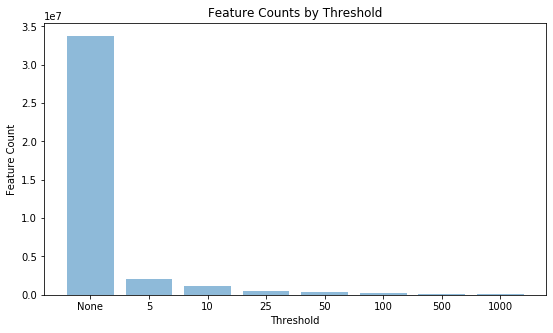

In [14]:
# plot feature counts by threshold

plt.figure(figsize=(9, 5))


Ts = ['None'] + [f"{threshold}" for threshold in thresholds]
y_pos = np.arange(len(Ts))

plt.bar(y_pos, feat_num, align='center', alpha=0.5)
plt.xticks(y_pos, Ts)
plt.ylabel('Feature Count')
plt.xlabel('Threshold')
plt.title('Feature Counts by Threshold')

In [15]:
# show the distinct value count for all categorical variables for all thresholds and the summary at the bottom

eda2_summary = distinct_summary + [["***Total***"] + [str(num) for num in feat_num]]
eda2_summary = eda2_summary + [["***% Preserved***"] + [str(round(percent*100,1))+"%" for percent in feat_percent_preserv]]


distinctCounts = spark.createDataFrame(eda2_summary, ['Feature', 'Distinct'] + [f"count >= {threshold}" for threshold in thresholds] )
distinctCounts.show(40)

+-----------------+--------+----------+-----------+-----------+-----------+------------+------------+-------------+
|          Feature|Distinct|count >= 5|count >= 10|count >= 25|count >= 50|count >= 100|count >= 500|count >= 1000|
+-----------------+--------+----------+-----------+-----------+-----------+------------+------------+-------------+
|   cate_feature_1|    1460|      1461|       1458|       1433|       1394|         701|         295|          213|
|   cate_feature_2|     583|       558|        555|        552|        551|         540|         516|          482|
|   cate_feature_3|10131227|    413575|     193949|      77902|      40203|       21055|        4869|         2585|
|   cate_feature_4| 2202608|    248610|     138801|      68146|      40360|       23839|        6475|         3556|
|   cate_feature_5|     305|       306|        306|        302|        290|         182|          97|           73|
|   cate_feature_6|      24|        22|         19|         17|         

__EDA 2 Findings:__

> In this section, we found that most of the values of the categorical features have very few counts. Even a threshold of five occurance would cause a drastic drop in feature number (refer to the bar graph above). Looking at the row, `***% Preserved***` in the table above, we only have 6.2% of the values left if we set the threshold for minimum occurance to be 5 and 3.2% left when the threshold is set to 10. This piece of information helps inform the feature engineering. As part of our feature engineering, we will attempt to establish a threshold to exclude these values having very low occurances so we don't train our model with local trend that doesn't exist in the population. 

> Rare values does not equal missing value. Therefore, we will also explore to assign a special value to those rare values so the algorithm can distinguish them from missing data and observe this practice's impact on model performance.

> Looking at the counts of features left after a given threshold is applied (row, `***Total***` in the table above), we can see that when the threshold is set to ten, we would still have around 1 million one-hot-encoded features, and we can guarantee that all the parameters in our models are trained as least on ten examples. Therefore, we will set the threshold at ten to filter our categorical values. 



## EDA 3: Integer Features

In this section, we perform an EDA on the integer features (i.e., the first 13 features). The goal is to identify possible feature engineering that could potentially improve our algorithm's performance.

In [16]:
train_parquet.select(intFieldNames[:7]).describe().show()
train_parquet.select(intFieldNames[6:]).describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|     int_feature_1|     int_feature_2|     int_feature_3|    int_feature_4|     int_feature_5|     int_feature_6|     int_feature_7|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|          25047061|          45840617|          36001170|         35903248|          44657500|          35588289|          43857751|
|   mean|3.5024133170754044|105.84841979766546|26.913041020611274|7.322680248873305|18538.991664871523|116.06185085211598|16.333130032135028|
| stddev| 9.429076407105093| 391.4578226870699|397.97258302273343|8.793230712645762|  69394.6018462232|382.56644937123986| 66.04975524511694|
|    min|                 0|                -3|                 0|                0|                 0|                 0|                 0|
|    m

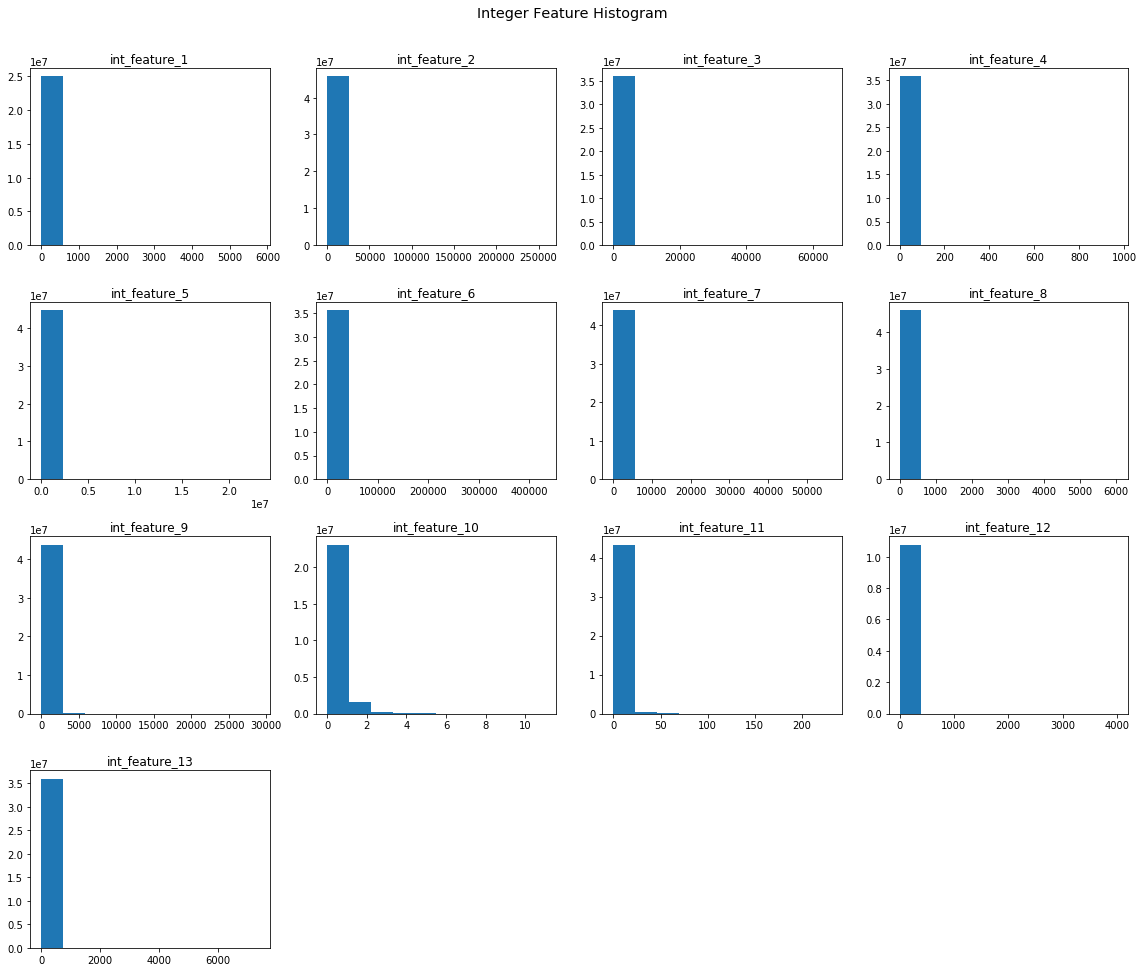

In [17]:
fig = plt.figure(figsize=(16, 16))
for i in range(len(intFieldNames)):
    colName = intFieldNames[i]
    ax = plt.subplot(5, 4, i+1)
    ax.hist(train_parquet.select(colName).rdd.map(lambda r: r[0]).filter(lambda x: x!=None).collect())
    ax.set_title(colName)

st = fig.suptitle("Integer Feature Histogram", fontsize="x-large")
fig.tight_layout()
st.set_y(1.03)

__EDA 3 Findings:__

From both the histograms and statistics summary, we can see that most of the integer features are very right-skewed with outliers. When fitting to the integers without any feature engineering, we might give the outliers more than appropriate weight in affecting our model's decision-making. Therefore, it is worth it to try transforming the integers by taking the natural log of its values. We will compare the performance of the model with and without the log transformation.

===================================================================================================================================

# __Section 4__ - Algorithm Implementation

## Feature Engineering

We start section 4 with our default feature engineering based on the EDA in section 3 that we think can improve the performance of our model.

### Categorical Variables

We replace the categorical values having counts less than 10 occurances with a special value `***` to prevent overfitting and distinguishing them from missing values.

In [18]:
#set the default threshold at 10
threshold = 10

train_parquet_MD = train_parquet

# transform data column by column
for col in cateFieldNames:
    valuesToKeep = train_parquet.groupBy(col).count().filter(f"count >= {threshold}").select(col)
    valuesToKeep = valuesToKeep.withColumn("_"+col, train_parquet[col])
    valuesToKeep = valuesToKeep.drop(col)

    train_parquet_MD = train_parquet_MD.join(F.broadcast(valuesToKeep), train_parquet_MD[col] == valuesToKeep["_"+col], 'leftouter')
    train_parquet_MD = train_parquet_MD.withColumn(col, F.when(F.col("_"+col).isNull(), "***").otherwise(F.col("_"+col)))
    train_parquet_MD = train_parquet_MD.drop("_"+col)
    

In [19]:
# view data after the replacement
train_parquet_MD.show(5)

+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|label|int_feature_1|int_feature_2|int_feature_3|int_feature_4|int_feature_5|int_feature_6|int_feature_7|int_feature_8|int_feature_9|int_feature_10|int_feature_11|int_feature_12|int_feature_13|cate_feature_1|cate_feature_2|cate_feature_3|cate_feature_4|cate_feature_5|cate_feature_6|cate_feature_7|cate_feature_8|cate_feature_9|cate_feature_10|cate_feature_11|cate_feature_12|cate_feature_13|cate_fe

### Numeric Variables

By default, we take the floor of the log of the numerical value + 2. 
> Log transform is aimming to reduce the potentially drastic effect out outliers can have in the model.  
> The +2 is to prevent 0 becoming undefined and to separate 0 from 1 because 0 might have a more special meaning than value >= 1 since it represents the total absence of something.  
> ($\lfloor log(0+2) \rfloor = 0$, $\lfloor log(i+2) \rfloor = 0, where\ i=\{1,2,3,4,5\}$)

In [20]:
# transform data column by column
for col in intFieldNames:
    train_parquet_MD = train_parquet_MD.withColumn(col, F.floor(F.log(F.col(col)+F.lit(1))))

In [21]:
# view data after the transformation
train_parquet_MD.show(5)

+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|label|int_feature_1|int_feature_2|int_feature_3|int_feature_4|int_feature_5|int_feature_6|int_feature_7|int_feature_8|int_feature_9|int_feature_10|int_feature_11|int_feature_12|int_feature_13|cate_feature_1|cate_feature_2|cate_feature_3|cate_feature_4|cate_feature_5|cate_feature_6|cate_feature_7|cate_feature_8|cate_feature_9|cate_feature_10|cate_feature_11|cate_feature_12|cate_feature_13|cate_fe

### Hashing

All four of the models we discussed in section 2 were parametric models. In order to train and use parametric models, we need to transform the text of categorical data so that they are represented by numbers. The most straight forward way to tackle this task is one-hot-encoding where for each category, a distinct value is represented by their position in the vector and a value of one in the position.

In our project, we decided to use the hashing trick: https://en.wikipedia.org/wiki/Feature_hashing  
The core idea of feature hash is simple: Instead of making a one-to-one mapping of a categorical value to a position and a number in the feature vector, we use a hashing function to decide the location of a categorical value in our feature vector, which usually has a lower dimension than the dimension of our features. 

Just like any other hashing methods, collision might occur (collision is bound to happen when hashing to a lower dimension), where two distinct features are hashed to the same location. Yet, empirical findings have suggusted that for very sparse feature space, it doesn't significantly impact performance. Since data is sparse, it is unlikely that a single feature can have great impact in the model performance. A collision is only catastrophic when two very important features collide but it is unlikely for sparse data since it's rare to have one deciding feature and the odds of two extremely features colliding in a large space is even lower. In some cases, collision brings in noise to our training data resulting in less overfitting and improved performance. 

In this project we consider to use feature hashing due to the following advantages it has over one-hot-encoding:
1. It is faster than buiding the one-to-one mapping needed for one-hot-encoding
2. We don't need to store that mapping in memory for lookup for transforming unseen data come inference time.
3. We don't need to deal with unseen feature come inference time.

_source: https://dzone.com/articles/feature-hashing-for-scalable-machine-learning_

In [22]:
# set the number of feature to 50000 about twice as much as the average feature count for each column. 
# This number is to be higher when using non-field-aware methods
n_features = 50000 
n_fields = len(intFieldNames) + len(cateFieldNames)

# hash the features
hasher = FeatureHasher()
# the default is to hash integer features as categorical
hasher.setCategoricalCols(intFieldNames)
hasher.setNumFeatures(n_features)

for col in intFieldNames + cateFieldNames:
    hasher.setInputCols([col])
    hasher.setOutputCol(col+"_hashed")
    train_parquet_MD = hasher.transform(train_parquet_MD)
 

hashed_columns = train_parquet_MD.schema.names[-n_fields:]

# Convert values to hashes
def parse_sparse_vectors(vector, field_ind):
    """
    Helper function which takes in a sparse vector and field number and emit a tuple of (FIELD_NUMBER, FEATURE_NUMBER)
    
    Args:
        vector  - a sparse vector with the hash
        field_ind  - the field index of the feature
    Returns:
        a tuple of (FIELD_NUMBER, FEATURE_NUMBER)
    """
    if vector.indices.size > 0:
        return int(vector.indices[0])
    else:
        return None
# build a udf with the function parse_sparse_vectors
vector_parser = F.udf(parse_sparse_vectors, types.IntegerType())

train_parquet_hashed = train_parquet_MD

# convert the sparse vectors to tuples of (FIELD_NUMBER, FEATURE_NUMBER)

for field_ind, col in enumerate(hashed_columns):
    train_parquet_hashed = train_parquet_hashed.withColumn(col, vector_parser(col, F.lit(field_ind)))

train_parquet_hashed = train_parquet_hashed.drop(*(intFieldNames + cateFieldNames))

In [24]:
# view the hashed df
train_parquet_hashed.show(5)

+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|label_hashed|int_feature_1_hashed|int_feature_2_hashed|int_feature_3_hashed|int_feature_4_hashed|int_feature_5_hashed|

We have preprocessed our training data according with the default values suggested by our EDA. The next step is to train our FFM model.

=================================================================================================================================================

## FFM

__Noah's Section for FFM__

===============================================================================================================================================

## Logistic Regression

We will use the logistic regression from Spark ML to build a model using the 80% of the training set, and calculate the average log loss on the 20% of the heldout set.

In [31]:
#similar feature engineering process to FFM

threshold = 10

train_parquet_MD = train_parquet

for col in cateFieldNames:
    valuesToKeep = train_parquet.groupBy(col).count().filter(f"count >= {threshold}").select(col)
    valuesToKeep = valuesToKeep.withColumn("_"+col, train_parquet[col])
    valuesToKeep = valuesToKeep.drop(col)

    train_parquet_MD = train_parquet_MD.join(F.broadcast(valuesToKeep), train_parquet_MD[col] == valuesToKeep["_"+col], 'leftouter')
    train_parquet_MD = train_parquet_MD.withColumn(col, F.when(F.col("_"+col).isNull(), "***").otherwise(F.col("_"+col)))
    train_parquet_MD = train_parquet_MD.drop("_"+col)

train_parquet_MD.show(5)

for col in intFieldNames:
    train_parquet_MD = train_parquet_MD.withColumn(col, F.floor(F.log(F.col(col)+F.lit(2))))

train_parquet_MD.show(5)

n_features = 1000000 #hash to a set of 1 million feature since it's not field aware and we have a total of 1085739 feature according to EDA


hasher = FeatureHasher(inputCols=intFieldNames + cateFieldNames, outputCol="features")
hasher.setCategoricalCols(intFieldNames)
hasher.setNumFeatures(n_features)

df_hashed = hasher.transform(train_parquet_MD).select("label", "features").cache()

df_hashed.show(5)

+-----+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|label|int_feature_1|int_feature_2|int_feature_3|int_feature_4|int_feature_5|int_feature_6|int_feature_7|int_feature_8|int_feature_9|int_feature_10|int_feature_11|int_feature_12|int_feature_13|cate_feature_1|cate_feature_2|cate_feature_3|cate_feature_4|cate_feature_5|cate_feature_6|cate_feature_7|cate_feature_8|cate_feature_9|cate_feature_10|cate_feature_11|cate_feature_12|cate_feature_13|cate_fe

In [32]:
# do a 20%, 80% split
heldOutDF, trainDF = df_hashed.randomSplit([0.2,0.8], seed = 5)

In [33]:
# fit a logistic regression model with L2 regularization and regularization parameter = 1
blor = LogisticRegression(regParam=0.1)
blorModel = blor.fit(trainDF)
result = blorModel.transform(heldOutDF).cache()

In [34]:
def calculateLogLoss(df, probCol='probability', labelCol='label'):
    def logloss(probVector, label):
        """
        udf which helps calculate the log loss of test set

        Args:
            probVector - a dense vector with first number as the predicted probability of label being 0
            label      - the true label of an instance
        Returns:
            the log loss of a instance
        """
        import math
        # get the predicted probability of label = 0
        probability = probVector[0]
        # convert label to a float for calculation
        label = float(label)

        return -1.0 * (label*math.log(1-probability)+(1.0-label)*math.log(probability))
    
    # create an udf for dataframe
    cal_logloss = F.udf(logloss, types.DoubleType())
    
    # calculate the average log loss in the input dataframe
    meanLoss = df.withColumn("loss", cal_logloss('probability','label')).agg(F.avg("loss")).collect()
    
    return meanLoss

In [35]:
result.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(1000000,[1,63097...|[3.04323408301368...|[0.95448952211045...|       0.0|
|    0|(1000000,[13,1510...|[2.82499730621538...|[0.94401177856229...|       0.0|
|    0|(1000000,[13,2717...|[3.14050066054781...|[0.95853278536500...|       0.0|
|    0|(1000000,[21,1643...|[3.53950764318955...|[0.97179121816449...|       0.0|
|    0|(1000000,[29,2717...|[3.30615615511194...|[0.96463940028366...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [36]:
calculateLogLoss(result)

[Row(avg(loss)=0.08608094434475863)]

# __Section 5__ - Course Concepts

### Map Reduce Paradigm

Our FFM algorithm is implemented by iteratively using a series of map-reduce tasks. At the beginning of each iteration, we  broadcast the current weight matrix of latent vectors to all worker nodes. The first map-reduce task then begins, with the mapper reading the broadcast latent vectors to calculate the predicted click-through-rate for each impression. A second map-reduce task is then used to update the weight matrix (using gradient descent methods) for the next iteration of the algorithm. In this second map-reduce task, the mapper is used to compute the sub-gradients on each partition of the data. The reduce phase of then aggregates the sub-gradients and generates a single gradient update for our weight matrix of latent vectors. This is closely related to the approach of using Map-Reduce to run OLS in Homework 4 in parallel.

### Gradient Descent - Batch vs Stochastic

As previously noted, Juan, Zhuang, Chin, & Lin utilize stochastic gradient descent for their implementation of FFM. They are able to do this by making use of the Hogwild algorithm to parallelize the algorithm across multiple cores with shared memory. This was not possible for our implementation using distributed computation without shared memory in Pyspark. In order to implement stochastic gradient descent, we would have had to repeatedly broadcast a massive array of coefficients and gradients, which is computationally infeasible. As such, we opted instead to implement a parallelized version of batch gradient descent to reduce the need for large shuffles and network communcation. This also prevented potential issues with synchronization of updates.


### One-Hot Encoding, Sparse Data

Given the raw structure of our data, we were faced with several decisions about how to represent and engineer our features. With many categorical variables, one possibility was to use one-hot encoding, essentially creating indicator variables for every feature within every category. Yet as seen in our EDA, each categorical variable had an enormous number of distinct features. A one-hot encoded representation of the dataset thus would have been very large, and very sparse. Instead, we elected to represent our data using feature hashing, as Juan, Zhuang, Chin, and Lin. With this method, each feature is simply encoded as `(field_index,feature_index)` since all values are one because integer features are all so treated as categorical after log transfomation. Therefore, instead of a size of data insteading of being feature number times number of instances, it is 39 times the number of instances. This leads to a much more efficient use of space for our dataset.